# creating search engine

In [93]:
import os
import pandas as pd
import numpy as np
import pickle
import spacy
from tqdm import tqdm
import matplotlib.pyplot as plt
from gensim.models.fasttext import FastText
!pip install rank_bm25 --quiet #install BM25
!pip install --no-binary :all: nmslib #install nmslib
from rank_bm25 import BM25Okapi
import nmslib
import time

import utils
# drive.mount('/content/drive') # if you want to use G Drive
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')


<ipython-input-93-9c818b3af214>:17: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [6]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


### Load data and create DF

In [2]:
df = pd.read_csv("data/arxiv_smaller.csv")
df.head()

,Unnamed: 0,authors,title,categories,abstract,update_date,month,year
0,0,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",Calculation of prompt diphoton production cross sections at Tevatron and\n LHC energies,High Energy Physics - Phenomenology,"A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with data from the Fermilab Tevatron, and predictions are made for\nmore detailed tests with CDF and DO data. Predictions are shown for\ndistributions of diphoton pairs produced at the energy of the Large Hadron\nCollider (LHC). Distributions of the diphoton pairs from the decay of a Higgs\nboson are contrasted with those produced from QCD processes at the LHC, showing\nthat enhanced sensitivity to the signal can be obtained with judicious\nselection of events.\n",2008-11-26,november,2008
1,1,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,NaN,"We describe a new algorithm, the $(k,\ell)$-pebble game with colors, and use\nit obtain a characterization of the family of $(k,\ell)$-sparse graphs and\nalgorithmic solutions to a family of problems concerning tree decompositions of\ngraphs. Special instances of sparse graphs appear in rigidity theory and have\nreceived increased attention in recent years. In particular, our colored\npebbles generalize and strengthen the previous results of Lee and Streinu and\ngive a new proof of the Tutte-Nash-Williams characterization of arboricity. We\nalso present a new decomposition that certifies sparsity based on the\n$(k,\ell)$-pebble game with colors. Our work also exposes connections between\npebble game algorithms and previous sparse graph algorithms by Gabow, Gabow and\nWestermann and Hendrickson.\n",2008-12-13,december,2008
2,2,Hongjun Pan,The evolution of the Earth-Moon system based on the dark matter field\n fluid model,General Physics,"The evolution of Earth-Moon system is described by the dark matter field\nfluid model proposed in the Meeting of Division of Particle and Field 2004,\nAmerican Physical Society. The current behavior of the Earth-Moon system agrees\nwith this model very well and the general pattern of the evolution of the\nMoon-Earth system described by this model agrees with geological and fossil\nevidence. The closest distance of the Moon to Earth was about 259000 km at 4.5\nbillion years ago, which is far beyond the Roche's limit. The result suggests\nthat the tidal friction may not be the primary cause for the evolution of the\nEarth-Moon system. The average dark matter field fluid constant derived from\nEarth-Moon system data is 4.39 x 10^(-22) s^(-1)m^(-1). This model predicts\nthat the Mars's rotation is also slowing with the angular acceleration rate\nabout -4.38 x 10^(-22) rad s^(-2).\n",2008-01-13,january,2008
3,3,David Callan,A determinant of Stirling cycle numbers counts unlabeled acyclic\n single-source automata,Combinatorics,We show that a determinant of Stirling cycle numbers counts unlabeled acyclic\nsingle-source automata. The proof involves a bijection from these automata to\ncertain marked lattice paths and a sign-reversing involution to evaluate the\ndeterminant.\n,2007-05-23,may,2007
4,4,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\alpha}$,NaN,"In this paper we show how to compute the $\Lambda_{\alpha}$ norm, $\alpha\ge\n0$, using the dyadic grid. This result is a consequence of the description of\nthe Hardy spaces $H^p(R^N)$ in terms of dyadic and special atoms.\n",2013-10-15,october,2013


In [3]:
df.shape

(1879555, 8)

### Preprocess and tokenise
tokenizing the title, author, categories

In [5]:
nlp = spacy.load("en_core_web_md")

In [6]:
tok_title=[] # for our tokenised corpus

title = df.title.str.lower().values
title = [str(i) for i in title]
#Tokenising using SpaCy:
for doc in tqdm(nlp.pipe(title, n_threads=2, disable=["tagger", "parser","ner"])):
    tok = [t.text for t in doc if (t.is_ascii and not t.is_punct and not t.is_space)]
    tok_title.append(tok)

1879555it [01:33, 20028.35it/s]


In [7]:
tok_authors = []

author = df.authors.str.lower().values
author = [str(i) for i in author]

for doc in tqdm(nlp.pipe(author, n_threads=2, disable=["tagger", "parser","ner"])):
    tok = [t.text for t in doc if (t.is_ascii and not t.is_punct and not t.is_space)]
    tok_authors.append(tok)

1879555it [05:55, 5281.68it/s] 


In [8]:
tok_categories = []

categories = df.categories.str.lower().values
categories = [str(i) for i in categories]

for doc in tqdm(nlp.pipe(categories, n_threads=2, disable=["tagger", "parser","ner"])):
    tok = [t.text for t in doc if (t.is_ascii and not t.is_punct and not t.is_space)]
    tok_categories.append(tok)

1879555it [00:31, 59540.54it/s] 


### Fast text

In [9]:
ft_model_title = FastText(
    sg=1, # use skip-gram: usually gives better results
    # size=100, # embedding dimension (default)
    window=10, # window size: 10 tokens before and 10 tokens after to get wider context
    min_count=5, # only consider tokens with at least n occurrences in the corpus
    negative=15, # negative subsampling: bigger than default to sample negative examples more
    min_n=2, # min character n-gram
    max_n=5 # max character n-gram
)

ft_model_title.build_vocab(tok_title)

ft_model_title.train(
    tok_title,
    epochs=6,
    total_examples=ft_model_title.corpus_count, 
    total_words=ft_model_title.corpus_total_words)

ft_model_title.save('_fasttext_title.model')

In [10]:
ft_model_author = FastText(
    sg=1, # use skip-gram: usually gives better results
    # size=100, # embedding dimension (default)
    window=10, # window size: 10 tokens before and 10 tokens after to get wider context
    min_count=5, # only consider tokens with at least n occurrences in the corpus
    negative=15, # negative subsampling: bigger than default to sample negative examples more
    min_n=2, # min character n-gram
    max_n=5 # max character n-gram
)

ft_model_author.build_vocab(tok_authors)

ft_model_author.train(
    tok_authors,
    epochs=6,
    total_examples=ft_model_author.corpus_count, 
    total_words=ft_model_author.corpus_total_words)

ft_model_author.save('_fasttext_author.model')

In [11]:
ft_model_categories = FastText(
    sg=1, # use skip-gram: usually gives better results
    # size=100, # embedding dimension (default)
    window=10, # window size: 10 tokens before and 10 tokens after to get wider context
    min_count=5, # only consider tokens with at least n occurrences in the corpus
    negative=15, # negative subsampling: bigger than default to sample negative examples more
    min_n=2, # min character n-gram
    max_n=5 # max character n-gram
)

ft_model_categories.build_vocab(tok_categories)

ft_model_categories.train(
    tok_categories,
    epochs=6,
    total_examples=ft_model_categories.corpus_count, 
    total_words=ft_model_categories.corpus_total_words)

ft_model_categories.save('_fasttext_categories.model')

### Load fasttext and query

In [12]:
ft_model_title = FastText.load('_fasttext_title.model')
ft_model_author = FastText.load('_fasttext_author.model')
ft_model_categories = FastText.load('_fasttext_categories.model')

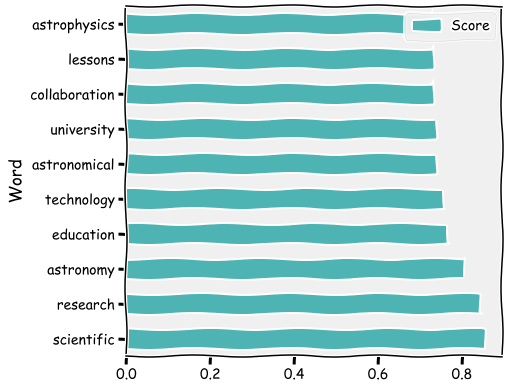

In [14]:
with plt.xkcd():
  pd.DataFrame(ft_model.wv.most_similar("science", topn=10, restrict_vocab=5000),columns=['Word','Score']).plot.barh(x='Word',figsize=(6,6),color=(0.3,0.7,0.7))

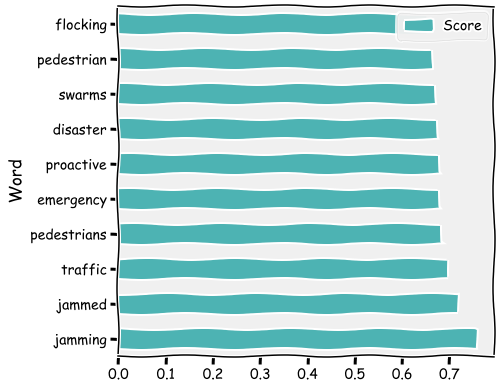

In [16]:
with plt.xkcd():
  pd.DataFrame(ft_model.wv.most_similar("jams", topn=10, restrict_vocab=10000),columns=['Word','Score']).plot.barh(x='Word',figsize=(6,6),color=(0.3,0.7,0.7))

### Creating BM25 document vectors:

In [18]:
bm25 = BM25Okapi(tok_title)
weighted_doc_vects = []

for i,doc in tqdm(enumerate(tok_title)):
  doc_vector = []
  for word in doc:
    vector = ft_model.wv[word]
    weight = (bm25.idf[word] * ((bm25.k1 + 1.0)*bm25.doc_freqs[i][word])) 
    / 
    (bm25.k1 * (1.0 - bm25.b + bm25.b *(bm25.doc_len[i]/bm25.avgdl))+bm25.doc_freqs[i][word])
    weighted_vector = vector * weight
    doc_vector.append(weighted_vector)
  doc_vector_mean = np.mean(doc_vector,axis=0)
  weighted_doc_vects.append(doc_vector_mean)

1879555it [01:55, 16340.40it/s]


In [13]:
bm25_title = BM25Okapi(tok_title)
weighted_doc_vects_title = []

for i,doc in tqdm(enumerate(tok_title)):
  doc_vector = []
  for word in doc:
    vector = ft_model_title.wv[word]
    weight = (bm25_title.idf[word] * ((bm25_title.k1 + 1.0)*bm25_title.doc_freqs[i][word])) 
    / 
    (bm25_title.k1 * (1.0 - bm25_title.b + bm25_title.b *(bm25_title.doc_len[i]/bm25_title.avgdl))+bm25_title.doc_freqs[i][word])
    weighted_vector = vector * weight
    doc_vector.append(weighted_vector)
  doc_vector_mean = np.mean(doc_vector,axis=0)
  weighted_doc_vects_title.append(doc_vector_mean)

1879555it [01:52, 16750.87it/s]


In [14]:
bm25_author = BM25Okapi(tok_authors)
weighted_doc_vects_author = []

for i,doc in tqdm(enumerate(tok_authors)):
  doc_vector = []
  for word in doc:
    vector = ft_model_author.wv[word]
    weight = (bm25_author.idf[word] * ((bm25_author.k1 + 1.0)*bm25_author.doc_freqs[i][word])) 
    / 
    (bm25_author.k1 * (1.0 - bm25_author.b + bm25_author.b *(bm25_author.doc_len[i]/bm25_author.avgdl))+bm25_author.doc_freqs[i][word])
    weighted_vector = vector * weight
    doc_vector.append(weighted_vector)
  doc_vector_mean = np.mean(doc_vector,axis=0)
  weighted_doc_vects_author.append(doc_vector_mean)

1879555it [02:04, 15040.87it/s]


In [15]:
bm25_categories = BM25Okapi(tok_categories)
weighted_doc_vects_categories = []

for i,doc in tqdm(enumerate(tok_categories)):
  doc_vector = []
  for word in doc:
    vector = ft_model_categories.wv[word]
    weight = (bm25_categories.idf[word] * ((bm25_categories.k1 + 1.0)*bm25_categories.doc_freqs[i][word])) 
    / 
    (bm25_categories.k1 * (1.0 - bm25_categories.b + bm25_categories.b *(bm25_categories.doc_len[i]/bm25_categories.avgdl))+bm25_categories.doc_freqs[i][word])
    weighted_vector = vector * weight
    doc_vector.append(weighted_vector)
  doc_vector_mean = np.mean(doc_vector,axis=0)
  weighted_doc_vects_categories.append(doc_vector_mean)

1879555it [00:32, 57637.17it/s]


In [17]:
pickle.dump(weighted_doc_vects_title, open( "weighted_doc_vects_title.p", "wb" ) )
pickle.dump(weighted_doc_vects_author, open( "weighted_doc_vects_author.p", "wb" ) )
pickle.dump(weighted_doc_vects_categories, open( "weighted_doc_vects_categories.p", "wb" ) )

### Load document vectors, build index and search:

In [18]:
with open( "weighted_doc_vects_title.p", "rb" ) as f:
  weighted_doc_vects_title = pickle.load(f)
# create a random matrix to index
data_title = np.vstack(weighted_doc_vects_title)

# initialize a new index, using a HNSW index on Cosine Similarity - can take a couple of mins
index_title = nmslib.init(method='hnsw', space='cosinesimil')
index_title.addDataPointBatch(data_title)
index_title.createIndex({'post': 2}, print_progress=True)

In [22]:
with open( "weighted_doc_vects_author.p", "rb" ) as f:
  weighted_doc_vects_author = pickle.load(f)

# create a random matrix to index
data_author = np.vstack(weighted_doc_vects_author)

# initialize a new index, using a HNSW index on Cosine Similarity - can take a couple of mins
index_author = nmslib.init(method='hnsw', space='cosinesimil')
index_author.addDataPointBatch(data_author)
index_author.createIndex({'post': 2}, print_progress=True)

In [23]:
with open( "weighted_doc_vects_categories.p", "rb" ) as f:
  weighted_doc_vects_categories = pickle.load(f)

# create a random matrix to index
data_categories = np.vstack(weighted_doc_vects_categories)

# initialize a new index, using a HNSW index on Cosine Similarity - can take a couple of mins
index_categories = nmslib.init(method='hnsw', space='cosinesimil')
index_categories.addDataPointBatch(data_categories)
index_categories.createIndex({'post': 2}, print_progress=True)

In [92]:
index_title.saveIndex("index_title.bin", save_data=True)
index_author.saveIndex("index_author.bin", save_data=True)
index_categories.saveIndex("index_categories.bin", save_data=True)

In [94]:
# querying the index:
query = 'computer science papers in march'

tokenized_input = utils.get_post(query)
dates = utils.get_dates(tokenized_input)
authors = utils.get_authors(tokenized_input)
text = utils.get_input(tokenized_input)
text, important = utils.time_important(text)
print(text)
print(important)

AttributeError: module 'utils' has no attribute 'time_important'

In [68]:
query_title = [ft_model_title.wv[vec] for vec in text]
query_title = np.mean(query_title,axis=0)

query_author = [ft_model_author.wv[vec] for vec in authors]
query_author = np.mean(query_author,axis=0)

query_categories = [ft_model_categories.wv[vec] for vec in text]
query_categories = np.mean(query_categories,axis=0)

t0 = time.time()

ids_title, distances_title = index_title.knnQuery(query_title, k=10)
if not np.isnan(query_author).any(): 
    ids_author, distances_author = index_author.knnQuery(query_author, k=10)
ids_categories, distances_categories = index_categories.knnQuery(query_categories, k=10)

t1 = time.time()

In [84]:
titles_df = df.iloc[ids_title]
titles_df['distances'] = pd.DataFrame(pd.Series(distances_title)).set_index(titles_df.index)
titles_df.reset_index(inplace=True)
results = titles_df

authors_df = df.iloc[ids_author]
authors_df['distances'] = pd.DataFrame(pd.Series(distances_author)).set_index(authors_df.index)
authors_df.reset_index(inplace=True)
results = pd.concat([authors_df, titles_df])

categories_df = df.iloc[ids_categories]
categories_df['distances'] = pd.DataFrame(pd.Series(distances_categories)).set_index(categories_df.index)
categories_df.reset_index(inplace=True)
results = pd.concat([results, categories_df])
                     
results.head()

<ipython-input-84-55768b2fad50>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titles_df['distances'] = pd.DataFrame(pd.Series(distances_title)).set_index(titles_df.index)
<ipython-input-84-55768b2fad50>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  authors_df['distances'] = pd.DataFrame(pd.Series(distances_author)).set_index(authors_df.index)
<ipython-input-84-55768b2fad50>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

,index,Unnamed: 0,authors,title,categories,abstract,update_date,month,year,distances
0,1116632,1116632,Benjamin Allaert and Isaac Ronald Ward and Ioan Marius Bilasco and\n Chaabane Djeraba and Mohammed Bennamoun,Optical Flow Techniques for Facial Expression Analysis -- a Practical\n Evaluation Study,Computer Vision and Pattern Recognition,"Optical flow techniques are becoming increasingly performant and robust when\nestimating motion in a scene, but their performance has yet to be proven in the\narea of facial expression recognition. In this work, a variety of optical flow\napproaches are evaluated across multiple facial expression datasets, so as to\nprovide a consistent performance evaluation. The aim of this work is not to\npropose a new expression recognition technique, but to understand better the\nadequacy of existing state-of-the art optical flow for encoding facial motion\nin the context of facial expression recognition. Our evaluations highlight the\nfact that motion approximation methods used to overcome motion discontinuities\nhave a significant impact when optical flows are used to characterize facial\nexpressions.\n",2021-01-06,january,2021,0.096008
1,1435099,1435099,"Quentin Fournier, Naser Ezzati-Jivan, Daniel Aloise, and Michel R.\n Dagenais",Automatic Cause Detection of Performance Problems in Web Applications,NaN,"The execution of similar units can be compared by their internal behaviors to\ndetermine the causes of their potential performance issues. For instance, by\nexamining the internal behaviors of different fast or slow web requests more\nclosely and by clustering and comparing their internal executions, one can\ndetermine what causes some requests to run slowly or behave in unexpected ways.\nIn this paper, we propose a method of extracting the internal behavior of web\nrequests as well as introduce a pipeline that detects performance issues in web\nrequests and provides insights into their root causes. First, low-level and\nfine-grained information regarding each request is gathered by tracing both the\nuser space and the kernel space. Second, further information is extracted and\nfed into an outlier detector. Finally, these outliers are then clustered by\ntheir behavior, and each group is analyzed separately. Experiments revealed\nthat this pipeline is indeed able to detect slow web requests and provide\nadditional insights into their true root causes. Notably, we were able to\nidentify a real PHP cache contention using the proposed approach.\n",2021-03-09,march,2021,0.100571
2,764415,764415,"Conor Sexton, Quentin Bodinier, Arman Farhang, Nicola Marchetti,\n Faouzi Bader, Luiz A. DaSilva",Coexistence of OFDM and FBMC for Underlay D2D Communication in 5G\n Networks,Networking and Internet Architecture,"Device-to-device (D2D) communication is being heralded as an important part\nof the solution to the capacity problem in future networks, and is expected to\nbe natively supported in 5G. Given the high network complexity and required\nsignalling overhead associated with achieving synchronization in D2D networks,\nit is necessary to study asynchronous D2D communications. In this paper, we\nconsider a scenario whereby asynchronous D2D communication underlays an OFDMA\nmacro-cell in the uplink. Motivated by the superior performance of new\nwaveforms with increased spectral localization in the presence of frequency and\ntime misalignments, we compare the system-level performance of a set-up for\nwhen D2D pairs use either OFDM or FBMC/OQAM. We first demonstrate that\ninter-D2D interference, resulting from misaligned communications, plays a\nsignificant role in clustered D2D topologies. We then demonstrate that the\nresource allocation procedure can be simplified when D2D pairs use FBMC/OQAM,\nsince the high spectral localization of FBMC/OQAM results in negligible\ninter-D2D interference. Specifically, we identify that FBMC/OQAM is best suited\nto scenarios consisting of small, densely populated D2D clusters lo

In [86]:
results.sort_values(by='distances')[:10]

,index,Unnamed: 0,authors,title,categories,abstract,update_date,month,year,distances
0,762270,762270,"Pawan Kumar Srivastava, Swasti Arya, Santosh Kumar and Subhasis Ghosh",Relativistic nature of carriers: Origin of electron-hole conduction\n asymmetry in m o n o l a ye r gr a p h e n e,Mesoscale and Nanoscale Physics,"We report electron-hole conduction asymmetry in monolayer graphene.\nPreviously, it has been claimed that electron-hole conduction asymmetry is due\nto imbalanced carrier injection from metallic electrodes. Here, we show that\nmetallic contacts have negligible impact on asymmetric conduction and may be\neither sample or device-dependent phenomena. Electrical measurements show that\nmonolayer graphene based devices exhibit suppressed electron conduction\ncompared to hole conduction due to the presence of donor impurities which\nscatter electrons more efficiently. This can be explained by the relativistic\nnature of charge carriers in a graphene monolayer and can be reconciled with\nthe fact that in a relativistic quantum system transport cross section does\ndepend on the sign of scattering potential in contrast to a nonrelativistic\nquantum system.\n",2017-12-20,december,2017,0.038026
1,1817950,1817950,"Doracelly Hincapie, Juan Ospina",Stochastic S-I-S-O-E Epidemic Model,NaN,An stochastic SIS epidemic model in an open environment is presented.\n,2007-05-23,may,2007,0.052066
2,1687884,1687884,"Anirban Kundu, Soumitra Nandi, Jyoti Prasad Saha",New Physics in b --> s bar(s) s Decay,High Energy Physics - Phenomenology,"We perform a model-independent analysis of the data on branching ratios and\nCP asymmetries of $B\to\phi K$ and $B\to\eta^{(')} K^{(*)}$ modes. The present\ndata is encouraging to look for indirect evidences of physics beyond the\nStandard Model. We investigate the parameter spaces for different possible\nLorentz structures of the new physics four-Fermi interaction. It is shown that\nif one takes the data at $1\sigma$ confidence level, only one particular\nLorentz structure is allowed. Possible consequences for the $B_s$ system are\nalso discussed.\n",2009-11-11,november,2009,0.053594
3,466738,466738,"Davood Momeni, Muhammad Raza, Ratbay Myrzakulov","Analytical coexistence of s, p, s + p phases of a holographic\n superconductor",High Energy Physics - Theory,"We analytically study the critical phase of a mixed system of the U(2) gauge\nfields and global symmetry on the boundary using gauge/gravity. A variational\nminimization problem has been formulated. The numerical results pertinently\nshow that there exists a minimum chemical potential in which both scalar\n(s-wave) and vector (p-wave) condensates exist in a mixture, as well as in the\ndistinct s- and p-phases. This result is obtained by breaking the symmetry into\nU(1) symmetry and rotational symmetry. While the analytical solutions of\ncondensates and charge densities are achieved in both cases: the balanced and\nunbalanced holographic superconductors. This is the first an- alytical study of\nthe coexistence of two modes of the superconductivity with different order\nparameters. The realistic model consists of two different phases of the\nsuperfluidity in Helium.\n",2015-04-07,april,2015,0.054373
4,1825888,1825888,Ch. C. Moustakidis and S. E. Massen,One-body density matrix and momentum distribution in s-p and s-d shell\n nuclei,Nuclear Theory,"Analytical expressions of the one- and two- body terms in the cluster\nexpansion of the one-body density matrix and momentum distribution of the s-p\nand s-d shell nuclei with N=Z are derived. They depend on the harmonic\noscillator parameter b and the parameter $\beta$ which originates from the\nJastrow correlation function. These parameters have been determined by least\nsquares fit to the experimental charge form factors. The inclusion of\nshort-range correlations increases the high momentum component of the momentum\ndistribution, $n({\bf k})$ for all nuclei we have considered while there is an\nA depend

In [69]:
min(distances_title)

0.038025856

In [70]:
min(distances_author)

0.096007824

In [71]:
min(distances_categories)

0.20117497

In [72]:
print(f'Searched {df.shape[0]} records in {round(t1-t0,4) } seconds \n')
for i,j in zip(ids_title,distances_title):
  print(round(j,2))
  print(df.title.values[i])

Searched 1879555 records in 0.2094 seconds 

0.04
Relativistic nature of carriers: Origin of electron-hole conduction
  asymmetry in m o n o l a ye r gr a p h e n e
0.05
Stochastic S-I-S-O-E Epidemic Model
0.05
New Physics in b --> s bar(s) s Decay
0.05
Analytical coexistence of s, p, s + p phases of a holographic
  superconductor
0.06
One-body density matrix and momentum distribution in s-p and s-d shell
  nuclei
0.06
Non-crossing partitions of type (e,e,r)
0.06
Critical current of a S/F-I-N/S tunnel structure in a parallel magnetic
  field
0.06
One-Particle Inclusive B sub s -> D bar sub s X Decays
0.07
Properties of the first excited state of 9Be derived from (gamma,n) and
  (e,e') reactions
0.07
T-dual R-R zero-norm states, D-branes and S-duality of type II string
  theory


In [77]:
for i,j in zip(ids_author,distances_author):
  print(round(j,2))
  print(df.title.values[i])

0.1
Optical Flow Techniques for Facial Expression Analysis -- a Practical
  Evaluation Study
0.1
Automatic Cause Detection of Performance Problems in Web Applications
0.1
Coexistence of OFDM and FBMC for Underlay D2D Communication in 5G
  Networks
0.11
Generative Art Using Neural Visual Grammars and Dual Encoders
0.11
Disorder-perturbed Landau levels in high electron mobility epitaxial
  graphene
0.11
Prediction of the thermophysical properties of molten salt fast reactor
  fuel from first-principles
0.11
A Nonparametric Bayesian Design for Drug Combination Cancer Trials
0.11
Transfer Learning Approach for Detecting Psychological Distress in
  Brexit Tweets
0.11
Evolving Intelligent Reflector Surface towards 6G for Public Health:
  Application in Airborne Virus Detection
0.11
Deriving Good LDPC Convolutional Codes from LDPC Block Codes


In [78]:
for i,j in zip(ids_categories,distances_categories):
  print(round(j,2))
  print(df.title.values[i])

0.2
Reply to Comment on "Chiral suppression of scalar glueball decay"
0.2
A new, very massive modular Liquid Argon Imaging Chamber to detect low
  energy off-axis neutrinos from the CNGS beam. (Project MODULAr)
0.2
Higgs and Z' Phenomenology in B-L extension of the Standard Model at LHC
0.2
Consistency checks of different pion-pion scattering data sets using
  forward dispersion relations
0.2
Fermionic states in pure 4D deconstruction
0.2
B->X_s l^+l^- in the MSSM at NNLO
0.2
The Higgs sector in the Next-to-MSSM
0.2
Radiative generation of R-parity violating Yukawa-like interactions from
  supersymmetry breaking
0.2
Probing Lepton Flavor Violation Signal Induced by R-violating Minimal
  Supersymmetric Standard Model at a Linear Collider
0.2
Signal for space-time noncommutativity: the Z -> gamma gamma decay in
  the renormalizable gauge sector of the theta-expanded NCSM


In [ ]:

def time_important(document): 
    influence = ['influential', 'important', 'pivotal', 'significant', 'leading', 'noteworthy']
    time = ['latest', 'recent', 'newest', 'current']
    text = ""
    for token in document: 
        if token is not in influence or time: 